<h1>Can an Artificial Intelligence Coach Special Teams?</h1>

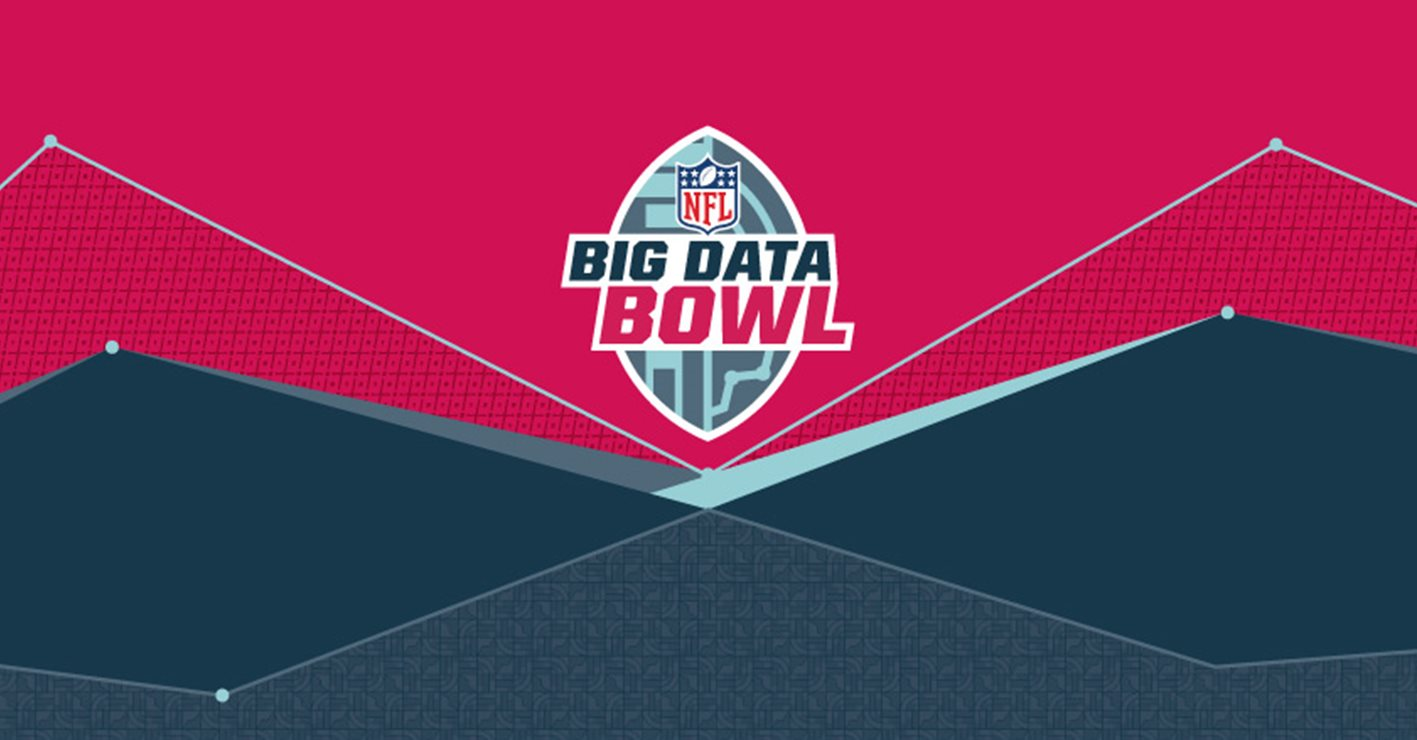

<h2>Introduction</h2>
<p>
A world class football coach may have a top secret playbook, mind blowing creativity and seemingly psychic intuition, skills which are learned through study, practice and experience. If these skills can be learned by a human, could they be learned by a machine?
<br><br>
The subject of artificial intelligence undertaking jobs traditionally completed by humans is frequently discussed across a wide variety of platforms and industries. This notebook will not answer the question of whether a special teams coach can be replaced by an artificial intelligence, there is far more to being a special teams coach than what can be learned from this data. However, it will take a step on the road to answering that question by attempting to train a Generative Adversarial Network (GAN) to generate new and unique punt plays. If it can learn how 22 players and the ball line up and react to each others movements then perhaps, with further work, it could predict the optimum location of the field to aim a punt or the return route that will yield the most yards.
</p>
<br>
<h2>Contents</h2>
<p>
    <ol>
        <li><a href='#1'>Configuration and Data Load</a></li>
        <li><a href='#2'>Data Setup</a></li>
        <li><a href='#3'>Data Analysis</a></li>
        <ul>
            <li><a href='#3.1'>Punt Outcomes</a></li>
            <li><a href='#3.2'>Number of Frames in a Punt Play</a></li>
        </ul>
        <li><a href='#4'>Training Data Construction</a></li>
        <li><a href='#5'>Creating the Generative Adversarial Network</a></li>
        <li><a href='#6'>Animation Setup</a></li>
        <li><a href='#7'>Results</a></li>
        <ul>
            <li><a href='#7.1'>Real Punt Example</a></li>
            <li><a href='#7.2'>Early Training Example</a></li>
            <li><a href='#7.3'>Mid-Training Example</a></li>
            <li><a href='#7.4'>Final Example</a></li>
        </ul>
        <li><a href='#8'>Conclusion</a></li>
    </ol>
</p>

<a id="1"></a>
<h2>1. Configuration and Data Load</h2>
<p>Importing the libraries needed in the notebook and loading the raw data.</p>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import math
import time
import os

In [ ]:
# Read in the data
root_dir = '../input/nfl-big-data-bowl-2022/'

li = []

tracking_cols = ['gameId','playId','displayName','position','nflId','position','playDirection','x','y','team','frameId']
for filename in ['tracking2018.csv', 'tracking2019.csv', 'tracking2020.csv']:
    df = pd.read_csv(root_dir + filename, index_col=None, header=0, usecols=tracking_cols)
    li.append(df)

tracking = pd.concat(li, axis=0, ignore_index=True)

play_cols = ['gameId','playId', 'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult']
plays = pd.read_csv(root_dir + 'plays.csv', usecols=play_cols)

print(f"Loaded in {len(plays)} plays and {len(tracking)} tracking records")

<a id="2"></a>
<h2>2. Data Setup</h2>
<h3>Global Data Fixes</h3>
<p>
Create a unique identifier by combining the playId, which is only unique within a game, and the gameId which is unique globally. This gives each play a global unique identifier.
<br><br>
During the period covered by the data the team known as the Raiders re-located from Oakland to Las Vegas. The team abbreviation used for the Raiders also changed from OAK to LV. To achieve consistency throughout the data all instances of the OAK team abbreviation will be renamed to LV.
<br><br>
The tracking data for the ball does not hold a position or an NFL ID. To ensure the ball can be separated from players within the tracking data, these values will be populated with some arbitrary values.
</p>
<h3>Filter Data</h3>
<p>
Select only the punt related data and clean up any irrelevant data.
</p>

In [ ]:
# combine gameid and playid to create a unique play id
tracking['playUniqueId'] = tracking['gameId'].astype(str) + tracking['playId'].astype(str)
plays['playUniqueId'] = plays['gameId'].astype(str) + plays['playId'].astype(str)

# Rename all instances of OAK to LV
plays.loc[plays['possessionTeam']=='OAK', 'possessionTeam'] = 'LV'

#Fill in some gaps in the tracking data for the football
tracking.loc[tracking['displayName']=='football', 'position'] = 'BLL'
tracking.loc[tracking['displayName']=='football', 'nflId'] = 99999.9

In [ ]:
# Filter for the punt data
punt_plays = plays.loc[plays['specialTeamsPlayType']=='Punt']
punt_tracking = tracking.loc[tracking['playUniqueId'].isin(punt_plays.playUniqueId.unique())]
print(f"There are {len(punt_plays)} punt plays and {len(punt_tracking)} punt tracking records")
# Tidy up data that is no longer needed
del plays
del tracking

<a id="3"></a>
<h2>3. Data Analysis</h2>

<a id="3.1"></a>
<h3>Punt Outcomes</h3>
<p>
The 8 different punt outcomes that can be split into 2 groups, ones where the ball was successfully punted and made it's way down field, and ones where the ball was not successfully punted. The outcomes in the first group, successful punts, are all individually more numerous than any of the categories in the second group, unsuccessful punts.
<br><br>
Successful Punts (in order of most numerous):
<ul>
<li>Return - the ball is caught by an opposing team player who then runs with the ball upfield to try and gain as many yards as possible before they are tackled or reach the opposing team end zone.</li>
<li>Fair Catch - the opposing player signals their intention not to advance the ball and in return is protected from tackles by opposing players.</li>
<li>Downed - the kicking team are the first to possess the ball after the punt. This is technically a spot foul where the ball was possessed, although a flag is generally not thrown. The receiving team start their drive from the yard line where the ball was first touched by a kicking team member.</li>
<li>Out of Bounds - the punt goes out of bounds before it is touched by a player. The receiving team start their drive from the yard line where the ball went out of bounds.</li>
<li>Touchback - the punt is dead within or beyond the receiving teams end zone. This can occur either by the punt travelling untouched through the end zone or by being caught by a receiving team player in the end zone who then takes a knee to end the play. The receiving team start their drive from the 25 yard line in this scenario.</li>
<li>Muffed - the ball strikes a player of the receiving team and goes loose but they did not possess the ball (if they possess the ball and then drop it it is a fumble). The ball can then be possessed by the kicking team again and, although they cannot advance it from the point they possess it, they will keep posession and a new set of downs from the yard line in which they gained possession.</li>
</ul>
<br><br>
The unsuccessful punt categories are:
<ul>
<li>Non-Special Teams Results - includes scenarios where a punt formation was used to mask a pass or a run.</li>
<li>Blocked Punt - an opposing team player blocked the punt as it was being kicked.</li>
</ul>
<br><br>
Based on the frequency of these outcomes an artificially generated punt should be more likely to show a returned punt than any other type of punt.
</p>

In [ ]:
# Chart the punt outcomes
mpl.rc('font', size=15) 
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)
ax = sns.histplot(data=punt_plays.specialTeamsResult)
ax.set_title('Punt Outcomes')

<a id="3.2"></a>
<h3>Number of Frames in a Punt Play</h3>
<p>
The length of a punt play can vary for example, a kick out of bounds would be much shorter than a zig-zagging return run. The length of a play is measured in the number of frames it occupies.
<br><br>
Most plays (5,981) have at least 57 frames, at this point a slow decline in the number of plays still happening starts to happen. A steep decline occurs between 87 frames, where the number of plays drops below 5,000, and 92 frames where the number of plays drops below 4,000. From here there is a more gradual decline with the below 3,000 occuring at 105 frames, below 2,000 at 119 frames and below 1,000 at 132 frames. At 140 frames 90% of the plays have finished leaving a long tail that continues out to 272 frames.
</p>

In [ ]:
# Create the plot data
frame_count = pd.DataFrame(punt_tracking.groupby('frameId').playUniqueId.nunique()).reset_index()# columns=['Frame No.', 'Count'])
frame_count.columns = ['Frame No.', 'Count']
# Create the chart
mpl.rc('font', size=15) 
plt.figure(figsize=(20, 6))
plt.xticks(rotation=90)
ax = sns.lineplot(x='Frame No.', y='Count', data=frame_count)
ax.set_title('Count of Plays with No. of Frames')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.set(xlim=(0, None))

<a id="4"></a>
<h2>4. Training Data Construction</h2>
<p>
To help the network learn I organise the data to make it as consistent as possible:
<ul>
<li>All plays are normalized so that the action occurs left to right</li>
<li>A small number of instances where the player kicking the punt has a position of 'K' (kicker) are amended so the position is 'P' (punter)</li>
<li>Field co-ordinates are scaled to values between -1 and 1</li>
</ul>
The distance of each player from the ball is calculated in an attempt to ensure that similar field positions occur in similar positions in the training data. To assist with this the value for the ball and punter are overridden to negative values. The receiving team players values are increased to ensure they are greater than the kicking team. Each frame is then sorted by distance from the ball which results in an order of:
<ol>
<li>Ball</li>
<li>Punter</li>
<li>Players from kicking team sorted by distance from ball</li>
<li>Players from receiving team sorted by distance from ball</li>
</ol>
To maintain a consistent size the number of frames to include is set at 140 which covers the entire play for 90% of the data (see abaove analysis). Any plays which are shorter than 140 frames are padded with zeroes, any plays which are longer are truncated so data beyond 140 plays is lost.
<br><br>
No filtering is done on the punt outcomes, all punt types are included in the training data.
</p>

In [ ]:
max_number_of_frames = 140

# RENAME ANY K VALUES TO P IN POSITION
def convert_k_to_p(df):
    df.loc[df['position']=='K', 'position'] = 'P'
    return df

# NORMALIZE THE COORDINATES SO ALL PLAYS PLAYED IN SAME DIRECTION
def flip_left_to_right(df):
    df.loc[df['playDirection']=='left', 'x'] = 120-df.loc[df['playDirection']=='left', 'x']
    df.loc[df['playDirection']=='left', 'y'] = 53.3-df.loc[df['playDirection']=='left', 'y']
    df.loc[:, 'playDirection'] = 'right'
    return df

def scale_coordinates(df):
    df.loc[:,'x'] = (df.loc[:,'x'] - 60)/60
    df.loc[:,'y'] = (df.loc[:,'y'] - 26.65)/26.65
    return df

# Organize the players so that they appear in order ball, punter, punting team, receiving team with punting teama dn receiving team ordered by distance from ball
def sort_by_distance_from_ball(players):
    # Create an array to hold the sorted value
    sorted_ids = []
    # Get the ball
    ball = players.loc[players['position']=='BLL'].iloc[0]
    punter = players.loc[players['position']=='P'].iloc[0]
    # Calculate every players distance from the ball
    players.loc[:, 'distanceFromBall'] = players.apply(lambda x: abs(math.dist([ball['x'],ball['y']],[x['x'],x['y']])), axis=1)
    # Override the distance of the ball itself and the punter so that they appear in indexes 0 and 1
    players.loc[players['position']=='BLL', 'distanceFromBall'] = -99.9
    players.loc[players['position']=='P', 'distanceFromBall'] = -49.9
    # Add 100 yards to the receiving team so that they are sorted lower than the kicking team and appear in the last 11 indexes
    players.loc[~players['team'].isin(['football',punter['team']]), 'distanceFromBall'] += 100.0 
    # Sort the players
    players = players.sort_values(by='distanceFromBall', ascending=True)
    # Return the array
    return players

def create_input_data(play_tracking):
    # Get a consistent position value for the punter (sometimes position is marked as K for kicker)
    play_tracking = convert_k_to_p(play_tracking)
    # Transform all plays so they are in same direction
    play_tracking = flip_left_to_right(play_tracking)
    # Scale the coordinates to a range of -1 to 1
    play_tracking = scale_coordinates(play_tracking)
    # Sort the payers so there is some consistency to their order
    player_sorted_ids = sort_by_distance_from_ball(play_tracking.loc[play_tracking['frameId']==1])
    player_sorted_ids = player_sorted_ids[['nflId','distanceFromBall']].copy()
    # Add the sorting value to the data and sort by frame then distance
    play_tracking = pd.merge(play_tracking, player_sorted_ids, how='left', on='nflId')
    play_tracking = play_tracking.sort_values(by=['frameId','distanceFromBall'], ascending=True)
    # Create an array to hold the values
    input_array = []
    # Loop through each frame to add the data to the array
    for frame_no in range(1, (max_number_of_frames+1)):
        # Identify if there is data for that frame
        if frame_no <= play_tracking.frameId.max():
            # Append the x,y data to the input array
            input_array.append(play_tracking.loc[play_tracking['frameId']==frame_no, ['x','y']].values)
        else:
            # Create an array of [23, 2] filed with zero
            input_array.append(np.zeros((23, 2)))
    return input_array

In [ ]:
# Create the tensor for the training data. This is a sizeable operation so the tensor is saved and on subsequent runs reloaded instead of running again.
existing_examples_path = "../input/nfl-gan-data/training_examples.npy"

if not os.path.exists(existing_examples_path):
    training_examples = []
    for unique_play in punt_plays.playUniqueId.unique():
        unique_play_tracking = punt_tracking.loc[punt_tracking['playUniqueId']==unique_play]
        # Build the data
        example = create_input_data(unique_play_tracking)
        training_examples.append(example)
    training_examples = np.array(training_examples)
    # Save the examples so future runs not needed
    np.save('../input/nfl-gan-data/training_examples.npy', training_examples)
    
loaded_training_examples = np.load('../input/nfl-gan-data/training_examples.npy')

# Keep a play to use as an example later
example_punt_play = loaded_training_examples[-1]

<a id="5"></a>
<h2>5. Creating the Generative Adversarial Network</h2>
<p>
A generator is created, which feeds random data through a network to create a punt play. A discriminator is created, which determines whether a punt play is real or fake from a mix of examples containing generated and real punt plays. The output is then used to tune both networks so that the generator becomes better at generating convincing punt plays and the discriminator becomes better at detecting fake plays.
</p>

In [ ]:
BUFFER_SIZE = 12000
BATCH_SIZE = 128

os.environ['KMP_WARNINGS'] = '0'

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

train_dataset = tf.data.Dataset.from_tensor_slices(loaded_training_examples).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(35*6*8, use_bias=False, input_shape=(60,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((35, 6, 8)))
    assert model.output_shape == (None, 35, 6, 8)

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(1, 1), padding='same', use_bias=False, data_format='channels_last'))
    assert model.output_shape == (None, 35, 6, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(1, 1), padding='same', use_bias=False, data_format='channels_last'))
    assert model.output_shape == (None, 35, 6, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, data_format='channels_last'))
    assert model.output_shape == (None, 70, 12, 4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(4, (5, 5), strides=(1, 1), padding='same', use_bias=False, data_format='channels_last'))
    assert model.output_shape == (None, 70, 12, 4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', data_format='channels_last'))
    assert model.output_shape == (None, 140, 24, 2)

    model.add(layers.Cropping2D(cropping=((0,0), (0,1))))
    assert model.output_shape == (None, 140, 23, 2)

    return model

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[140, 23, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Training setup
generator = generator_model()
discriminator = make_discriminator_model()

# Set the optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# Checkpoints code
checkpoint_dir = '../input/nfl-gan-data/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop
EPOCHS = 500
noise_dim = 60
num_examples_to_generate = 256

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):

  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Save generated plays every 100 epochs
    if epoch % 100 == 0:
        generate_and_save_plays(generator,
                                 epoch + 1,
                                 seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_plays(generator,
                           epochs,
                           seed)

generated_plays_during_training = []

def generate_and_save_plays(model, epoch, test_input):
  predictions = model(test_input, training=False)
  if len(predictions) > 0:
      generated_plays_during_training.append(predictions)

In [ ]:
# Train the network, only run number of epochs from latest checkpoint
last_ckpt = tf.train.latest_checkpoint(
    checkpoint_dir, latest_filename=None
)
last_ckpt = int(last_ckpt.split("-")[-1])
net_epochs = EPOCHS - (last_ckpt*15) if last_ckpt < (EPOCHS/15) else 0
    
train(train_dataset, net_epochs)

In [ ]:
# Save the generated examples
if len(generated_plays_during_training) > 1:
    generated_examples = np.array(generated_plays_during_training)

    # Check if previous examples created and add the new ones to it.
    generated_examples_path = "../input/nfl-gan-data/generated_examples.npy"

    if os.path.exists(generated_examples_path):
        # Add the examples generated this run to ones generated previously
        all_loaded_generated_examples = np.load('../input/nfl-gan-data/generated_examples.npy')
        all_examples = np.concatenate((all_loaded_generated_examples, generated_examples), axis = 0)
        np.save('../input/nfl-gan-data/generated_examples', all_examples)
    else:
        np.save('../input/nfl-gan-data/generated_examples', generated_examples)
        all_examples = generated_examples

<a id="6"></a>
<h2>6. Animation Setup</h2>

<p>The animation of a play is adapted from a post created by JARON_MICHAL. See the post here - https://www.kaggle.com/jaronmichal/tracking-data-visualization </p>

In [ ]:
# THIS CODE CREATES THE FOOTBALL PITCH

import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# Change size of the figure
plt.rcParams['figure.figsize'] = [12, 8]
def drawPitch(width, height, color="w"):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10, width + 30), ylim=(-15, height + 5))
    plt.axis('off')

    # Grass around pitch
    rect = patches.Rectangle((-10, -5), width + 40, height + 10, linewidth=1, facecolor='#3f995b', capstyle='round')
    ax.add_patch(rect)
    ###################

    # Pitch boundaries
    rect = plt.Rectangle((0, 0), width + 20, height, ec=color, fc="None", lw=2)
    ax.add_patch(rect)
    ###################

    # vertical lines - every 5 yards
    for i in range(21):
        plt.plot([10 + 5 * i, 10 + 5 * i], [0, height], c="w", lw=2)
    ###################
        
    # distance markers - every 10 yards
    for yards in range(10, width, 10):
        yards_text = yards if yards <= width / 2 else width - yards
        # top markers
        plt.text(10 + yards - 2, height - 7.5, yards_text, size=15, c="w", weight="bold")
        # botoom markers
        plt.text(10 + yards - 2, 7.5, yards_text, size=15, c="w", weight="bold", rotation=180)
    ###################

    # yards markers - every yard
    # bottom markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [1, 3], color="w", lw=2)

    # top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - 1, height - 3], color="w", lw=2)

    # middle bottom markers
    y = (height - 18.5) / 2
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [y, y + 2], color="w", lw=2)

    # middle top markers
    for x in range(20):
        for j in range(1, 5):
            plt.plot([10 + x * 5 + j, 10 + x * 5 + j], [height - y, height - y - 2], color="w", lw=2)
    ###################

    # draw home end zone
    plt.text(2.5, (height - 15) / 2, "HOME", size=30, c="w", weight="bold", rotation=90)
    rect = plt.Rectangle((0, 0), 10, height, ec=color, fc="#0064dc", lw=2)
    ax.add_patch(rect)

    # draw away end zone    
    plt.text(111, (height - 15) / 2, "AWAY", size=30, c="w", weight="bold", rotation=-90)
    rect = plt.Rectangle((width + 10, 0), 10, height, ec=color, fc="#c80014", lw=2)
    ax.add_patch(rect)
    ###################
    
    # draw extra spot point
    # left
    y = (height - 3) / 2
    plt.plot([10 + 2, 10 + 2], [y, y + 3], c="w", lw=2)
    
    # right
    plt.plot([width + 10 - 2, width + 10 - 2], [y, y + 3], c="w", lw=2)
    ###################
    
    # draw goalpost
    goal_width = 6 # yards
    y = (height - goal_width) / 2
    # left
    plt.plot([0, 0], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    # right
    plt.plot([width + 20, width + 20], [y, y + goal_width], "-", c="y", lw=10, ms=20)
    
    return fig, ax

In [ ]:
%matplotlib ipympl
from matplotlib import animation
from IPython.display import HTML
def animate_generated_play(df):
    fig, ax = drawPitch(100, 53.3)
    play = df
    team_left, = ax.plot([], [], 'o', markersize=20, markerfacecolor="r", markeredgewidth=2, markeredgecolor="white", zorder=7)
    team_right, = ax.plot([], [], 'o', markersize=20, markerfacecolor="b", markeredgewidth=2, markeredgecolor="white", zorder=7)
    ball, = ax.plot([], [], 'o', markersize=10, markerfacecolor="black", markeredgewidth=2, markeredgecolor="white", zorder=7)
    drawings = [team_left, team_right, ball]

    def init():
        team_left.set_data([], [])
        team_right.set_data([], [])
        ball.set_data([], [])
        return drawings
    
    # Re-scale the generated examples
    def upscale_coordinates(coords):
        x,y = coords
        x = (x * 60) + 60
        y = (y * 26.65) + 26.65
        return [x, y]

    def draw_teams(i):
        X = []
        Y = []
        for coords in play[i][1:12]:
            x, y = upscale_coordinates(coords)
            X.append(x)
            Y.append(y)
        team_left.set_data(X, Y)
        
        X = []
        Y = []
        for coords in play[i][12:23]:
            x, y = upscale_coordinates(coords)
            X.append(x)
            Y.append(y)
        team_right.set_data(X, Y)

    def animate(i):
        draw_teams(i)
        x, y = upscale_coordinates(play[i][0])
        ball.set_data([x, y])
        return drawings
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=140, interval=100, blit=True)

    return HTML(anim.to_html5_video())

<a id="7"></a>
<h2>7. Results</h2>
<p>
In this section I compare a real punt play with plays generated by the model during the early, mid and final stages of training.    
</p>
<br>
<a id="7.1"></a>
<h3>Real Punt Play</h3>
<p>
A real play taken from the training data showing an actual punt play from the NFL. Things that define this as a real punt play include:
    <ol>
        <li>Initial positions of the players show:<ul> 
            <li>Members from either team lined up on opposing sides of the line of scrimmage.</li>
        <li>The punter located behind the rest of team, this gives the punter enough space to kick the ball before the opposing team can get near him and block the punt.</li>
        <li>The returner of the receiving team located much further down field than the rest of his team.</li></ul>
        <li>The ball initially travelling backwards from the snapper to the punter before moving forwards after the punter kicks it.</li>
        <li>The majority of players from both team moving towards the ball after it is caught/lands.</li>
    </ol>
These elements can be used to assess the realism of the punt plays created by the generator.
</p>

In [ ]:
animate_generated_play(example_punt_play)

In [ ]:
all_loaded_generated_examples = np.load('../input/nfl-gan-data/generated_examples.npy')

<a id="7.2"></a>
<h3>Early Training Example</h3>
<p>
The early output of the generator looks nothing like a real punt play. All players and the ball clustered around the centere of the pitch making seemingly random movements. None of the elements listed above that define a real punt play are present in this example.
</p>

In [ ]:
animate_generated_play(all_loaded_generated_examples[0][0])

<a id="7.3"></a>
<h3>Mid-Training Example</h3>
<p>By mid-training the output is starting to look more convincing. The initial position of the players and the ball look realistic, which covers point 1 of our checklist. However, the ball does not appear to travel from the snapper to the punter, instead it hangs around the line of scrimmage for a few frames before making it's way down field. There is movement of all the players towards the ball once it makes it's way down field though. Overall 2 out of 3 elements are already present midway through training.</p>

In [ ]:
animate_generated_play(all_loaded_generated_examples[4][0])

<a id="7.4"></a>
<h3>Final Example</h3>
<p>In the final output all initial player positions looks accurate, the ball travels in a realistic manner, and the players move as expected during a punt play.</p>

In [ ]:
predictions = generator(seed, training=False)
predictions = np.array(predictions)
animate_generated_play(predictions[0])

<a id="8"></a>
<h2>8. Conclusion</h2>
<p>
The aim of this notebook was to find out if a GAN could be trained to generate a realistic looking punt play. I believe this was achieved as output from the final model showed realistic starting positions and expected movements of both the players and the ball.
<br><br>
The practical applications for this work in it's current state are limited. A coach could generate and watch plays in the hope of seeing a new and unique formation or it could be used as a training tool to give players exposure to more punt plays in the hope they will obtain a greater intuition for how they play out.
<br><br>
This model was a proof of concept but, if the model was developed further, it could provide greater practical application. For example, if the starting position of the kicking team players were used as an input, the model could generate numerous examples from which monte carlo simulations could help inform which is the optimal running lane that will provide the punt returner with the greatest chance of the most yards.
<br><br>
Thanks for reading my analysis.
</p>